# Tranfer Learnning to Flower Recognition using PyTorch 🔥
This dataset contains labeled 4242 images of flowers.


### Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Data
You can download data from: [Flowers Recognition Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import random

def create_datasets(base_dir, output_dir, train_ratio=0.7, val_ratio=0.2):
    # Crear directorios principales en la ubicación de salida
    datasets = ['train', 'val', 'test']
    output_path = os.path.join(base_dir, output_dir)
    os.makedirs(output_path, exist_ok=True)

    for dataset in datasets:
        os.makedirs(os.path.join(output_path, dataset), exist_ok=True)

    # Lista de subcarpetas de flores en el directorio base
    flower_types = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Iterar sobre cada subcarpeta de tipo de flor
    for flower_type in flower_types:
        flower_dir = os.path.join(base_dir, flower_type)
        # Crear directorios para cada tipo de flor en train, val y test
        for dataset in datasets:
            os.makedirs(os.path.join(output_path, dataset, flower_type), exist_ok=True)

        # Lista de imágenes en la subcarpeta
        images = [f for f in os.listdir(flower_dir) if os.path.isfile(os.path.join(flower_dir, f))]
        random.shuffle(images)

        # Número de imágenes para cada conjunto
        total_images = len(images)
        train_end = int(train_ratio * total_images)
        val_end = train_end + int(val_ratio * total_images)

        # Dividir imágenes en train, val y test
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Mover imágenes a los directorios correspondientes
        for img in train_images:
            shutil.copy(os.path.join(flower_dir, img), os.path.join(output_path, 'train', flower_type, img))
        for img in val_images:
            shutil.copy(os.path.join(flower_dir, img), os.path.join(output_path, 'val', flower_type, img))
        for img in test_images:
            shutil.copy(os.path.join(flower_dir, img), os.path.join(output_path, 'test', flower_type, img))

# Configuración de rutas
base_dir = '/content/drive/My Drive/descomprimido/flowers'
output_dir = '/content/drive/My Drive/descomprimido/dataset'

# Crear datasets
create_datasets(base_dir, output_dir)

# **EXPLORACIÓN DE CONJUNTO DE DATOS**


---


Para definir el número de clases, los nombres de las clases y el número de imágenes para cada una de las carpetas de entrenamiento, validación y prueba:

1.   Obtener la lista de clases a partir de las subcarpetas en la carpeta de entrenamiento (`train`).
2.   Contar el número de imágenes en cada subcarpeta de entrenamiento para determinar el número de imágenes por clase.


In [ ]:
import os
dataset_path = '/content/drive/My Drive/descomprimido/dataset'
# Obtener la lista de clases a partir de las subcarpetas en la carpeta de entrenamiento
train_classes = [d for d in os.listdir(os.path.join(dataset_path, 'train')) if os.path.isdir(os.path.join(dataset_path, 'train', d))]

# Número de clases
num_classes = len(train_classes)
print("Número de clases:", num_classes)

# Nombre de las clases
print("Nombre de las clases:", train_classes)

# Número de imágenes por clase en la carpeta de entrenamiento
num_images_train = {}
for cls in train_classes:
    num_images_train[cls] = len(os.listdir(os.path.join(dataset_path, 'train', cls)))

print("Número de imágenes por clase en la carpeta de entrenamiento:")
for cls, num_images in num_images_train.items():
    print(f"- {cls}: {num_images}")

# Número de imágenes por clase en la carpeta de validacion
num_images_val = {}
for cls in train_classes:
    num_images_val[cls] = len(os.listdir(os.path.join(dataset_path, 'val', cls)))

print("Número de imágenes por clase en la carpeta de validación:")
for cls, num_images in num_images_val.items():
    print(f"- {cls}: {num_images}")


Número de clases: 5
Nombre de las clases: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Número de imágenes por clase en la carpeta de entrenamiento:
- daisy: 687
- dandelion: 962
- rose: 700
- sunflower: 659
- tulip: 896
Número de imágenes por clase en la carpeta de validación:
- daisy: 269
- dandelion: 378
- rose: 282
- sunflower: 261
- tulip: 357


Para ver una muestra de cada una de las clases en el conjunto de entrenamiento, se puede cargar una imagen de cada clase y mostrarla.

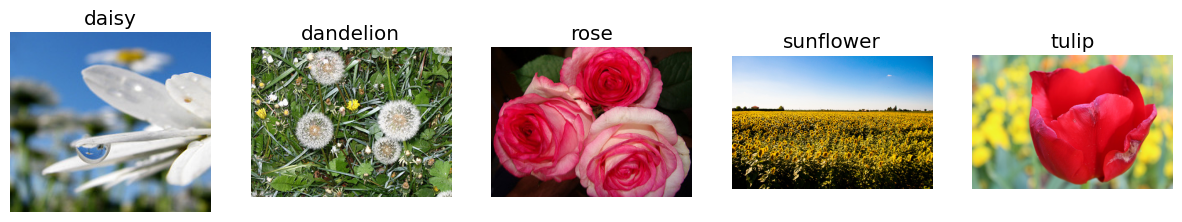

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Ruta de la carpeta dataset en Google Drive
dataset_path = '/content/drive/My Drive/descomprimido/dataset'

# Obtener la lista de clases a partir de las subcarpetas en la carpeta de entrenamiento
train_classes = [d for d in os.listdir(os.path.join(dataset_path, 'train')) if os.path.isdir(os.path.join(dataset_path, 'train', d))]

# Mostrar una muestra de cada clase
plt.figure(figsize=(15, 5))
for i, cls in enumerate(train_classes, start=1):
    # Obtener la ruta de la primera imagen de la clase
    img_name = os.listdir(os.path.join(dataset_path, 'train', cls))[0]
    img_path = os.path.join(dataset_path, 'train', cls, img_name)

    # Cargar la imagen
    img = Image.open(img_path)

    # Mostrar la imagen
    plt.subplot(1, len(train_classes), i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.show()


## **SELECCIÓN DE MODELO DE CLASIFICACIÓN**


---


Para el entrenamiento, usaremos una red ResNet18 previamente entrenada y la ajustaremos en nuestro conjunto de datos.

El siguiente código permite construir un modelo de CNN utilizando la arquitectura ResNet-18 con la opción de cargar pesos pre-entrenados

In [ ]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

num_classes = 5

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

num_classes = 5

def build_model(pretrained=True, fine_tune=True, num_classes= 5):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        print('[INFO]: Not loading pre-trained weights')
        model = models.resnet18(weights=None)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Cambia la capa de clasificaión final
    model.fc = nn.Linear(in_features=512, out_features=num_classes)
    return model

El número de clases se ha cambiado de 1000 (para ImageNet) a 5 (para nuestro conjunto de datos).

**Transfer Learning (Aprendizaje por Transferencia):**
* En el transfer learning, se utiliza un modelo pre-entrenado en una tarea relacionada y se transfieren sus conocimientos aprendidos a una nueva tarea. Esto implica tomar un modelo que ha sido entrenado en un conjunto de datos grande y general, como ImageNet, y aplicarlo a una tarea diferente pero relacionada, como la clasificación de imágenes médicas.
* Durante el transfer learning, se suelen mantener fijas las capas de la red neuronal convolucional (CNN) pre-entrenada y se reemplaza únicamente la capa de salida (o se agregan nuevas capas) para adaptarse a la nueva tarea.
* El objetivo principal del transfer learning es aprovechar los conocimientos previos aprendidos por el modelo pre-entrenado en la tarea original para acelerar y mejorar el rendimiento en la nueva tarea.



# **PREPARACIÓN DE DATOS**


---



# **DEFINICIÓN DE TRANSFORMACIONES**

Para mejorar la capacidad del modelo para generalizar a datos nuevos, se aplican transformaciones de aumento de datos, como el transpuesta horizontal, la rotación, el recorte aleatorio, para exponerlo a una variedad más amplia de ejemplos durante el entrenamiento.
Los aumentos ayudan a reducir el sobreajuste y también nos permiten entrenar durante más tiempo.
Aparte de eso, tanto para el conjunto de entrenamiento como para el de validación, usaremos los valores de normalización de ImageNet. Esto se debe a que estamos ajustando un modelo ResNet18 previamente entrenado.

In [ ]:
import torchvision.transforms as transforms

# Transformaciones para las imágenes de entrenamiento
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])

# Transformaciones para las imágenes de validación
valid_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])

# Transformaciones para las imágenes de prueba
test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])

Aquí está una explicación de cada una de las transformaciones que has aplicado:

* **Resize((224, 224)):** Esto redimensiona las imágenes a un tamaño de 224x224. Esta es una dimensión comúnmente utilizada en arquitecturas de redes neuronales convolucionales preentrenadas como ResNet.

* **RandomHorizontalFlip(p=0.5):** Esto realiza un volteo horizontal aleatorio en las imágenes con una probabilidad del 50%. Este tipo de transformación es útil para aumentar artificialmente el tamaño del conjunto de datos de entrenamiento y ayudar a la red neuronal a generalizar mejor.

* **RandomRotation(35):** Esto aplica una rotación aleatoria a las imágenes en el rango de -35 a +35 grados. Al igual que la transformación de volteo horizontal, esto ayuda a aumentar el conjunto de datos de entrenamiento y a mejorar la capacidad de generalización del modelo.

* **RandomAdjustSharpness(sharpness_factor=2, p=0.5):** Esta transformación ajusta la nitidez de las imágenes de manera aleatoria con una probabilidad del 50%. Aumentar la nitidez puede resaltar los bordes y detalles en las imágenes, lo que puede ayudar al modelo a aprender características más distintivas.

* **ToTensor():** Esta transformación convierte las imágenes PIL (Pillow) en tensores de PyTorch. Los modelos de PyTorch esperan tensores como entrada, por lo que esta transformación es necesaria para que las imágenes sean compatibles con el modelo.

* **Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):** Esta transformación normaliza los valores de píxel de las imágenes. Normalizar las imágenes ayuda a estandarizar la distribución de valores de píxel, lo que puede hacer que el entrenamiento de la red neuronal sea más estable y rápido. Los valores de media y desviación estándar especificados son los valores utilizados para normalizar las imágenes de ImageNet, en las que se entrenaron los modelos preentrenados. Esto es importante para garantizar que las imágenes de entrada tengan una distribución similar a la de las imágenes de entrenamiento originales de ImageNet.

En resumen, estas transformaciones están diseñadas para preprocesar las imágenes de entrenamiento, validación y prueba de manera consistente y adecuada para el entrenamiento de una red neuronal convolucional preentrenada en PyTorch.


**NOTA:** Para obtener resultados precisos y consistentes al evaluar un modelo entrenado, es fundamental aplicar las mismas transformaciones al conjunto de datos de prueba que se aplicaron durante el entrenamiento. Esto garantiza que el modelo vea y procese las imágenes de la misma manera en ambas etapas.

# **CARGA DE DATOS**
Se puede utilizar la biblioteca `torchvision.datasets.ImageFolder` para cargar las imágenes desde las subcarpetas de entrenamiento `train`, validación `val` y prueba `test` directamente en tensores de PyTorch.

In [ ]:
from torchvision.datasets import ImageFolder

# Cargar conjunto de datos de entrenamiento -  de manera automatica de realiza el encoder
train_dataset = ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transform)

# Cargar conjunto de datos de validación
val_dataset = ImageFolder(root=os.path.join(dataset_path, 'val'), transform=valid_transform)

# Cargar conjunto de datos de prueba
test_dataset = ImageFolder(root=os.path.join(dataset_path, 'test'), transform=test_transform)


La clase `ImageFolder` de PyTorch define automáticamente las etiquetas de las imágenes basándose en la estructura de las carpetas que contienen las imágenes. En concreto, cada subcarpeta dentro de la carpeta principal (por ejemplo, la carpeta de entrenamiento) se asocia con una etiqueta única.

En este caso, las etiquetas para las imágenes de 'daisy' serán 0, las etiquetas para las imágenes de 'dandelion' serán 1 y para las imágenes de 'rose' será 2. La clase `ImageFolder` asigna automáticamente estas etiquetas basándose en el orden alfabético de las subcarpetas dentro de la carpeta principal.

Puedes acceder a las etiquetas asignadas utilizando el atributo classes de `ImageFolder`.

In [ ]:
print(train_dataset.classes)  # Imprime las clases disponibles en el conjunto de entrenamiento


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Se accede a las etiquetas asignadas por `ImageFolder` y relacionarlas con las clases correspondientes utilizando el atributo `class_to_idx`. Este atributo es un diccionario que mapea el nombre de la clase al índice asignado por `ImageFolder`.

El siguiente fragmento de código crea un diccionario llamado `idx_to_class` que mapea las etiquetas numéricas asignadas por `ImageFolder` a las clases correspondientes. Luego, imprime este mapeo para ver la relación entre las etiquetas y las clases.

In [ ]:
# Obtener el diccionario de mapeo de clases a índices
class_to_idx = train_dataset.class_to_idx

# Invertir el diccionario para mapear los índices a las clases
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Imprimir el mapeo de etiquetas a clases
print("Mapeo de etiquetas a clases:")
for label, class_name in idx_to_class.items():
    print(f"Etiqueta: {label}, Clase: {class_name}")

Mapeo de etiquetas a clases:
Etiqueta: 0, Clase: daisy
Etiqueta: 1, Clase: dandelion
Etiqueta: 2, Clase: rose
Etiqueta: 3, Clase: sunflower
Etiqueta: 4, Clase: tulip


**NOTA:**
* **Conjunto de datos de validación:** Se utiliza durante el entrenamiento para ajustar los hiperparámetros del modelo y evitar el sobreajuste. Se utiliza para evaluar el rendimiento del modelo en datos no vistos durante el entrenamiento y tomar decisiones sobre la configuración del modelo.
* **Conjunto de datos de prueba:** Se utiliza después de finalizar el entrenamiento del modelo para evaluar su rendimiento final. Proporciona una evaluación imparcial del rendimiento del modelo en datos completamente nuevos que no se han utilizado en absoluto durante el entrenamiento o la validación.

# **DATALOADERS**

Para crear `dataloaders` en PyTorch, se puede utilizar la clase `DataLoader`. Esta clase se utiliza para cargar los datos en lotes durante el entrenamiento y la evaluación del modelo. Aquí se muestra cómo crear `dataloaders` para los conjuntos de datos de entrenamiento, validación y prueba:

In [ ]:
import torch
from torch.utils.data import DataLoader

# Suponiendo que tienes los conjuntos de datos 'train_dataset', 'val_dataset' y 'test_dataset'

# Definir el tamaño del lote (batch size)
batch_size = 32

# Crear dataloaders para los conjuntos de datos
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Verificar la longitud de los dataloaders
print(f"Número de lotes en el conjunto de entrenamiento: {len(train_loader)}")
print(f"Número de lotes en el conjunto de validación: {len(val_loader)}")
print(f"Número de lotes en el conjunto de prueba: {len(test_loader)}")


Número de lotes en el conjunto de entrenamiento: 122
Número de lotes en el conjunto de validación: 49
Número de lotes en el conjunto de prueba: 26


**¿Por qué `shuffle=True` en `dataloader` de entrenamiento?**

El parámetro `shuffle=True `se utiliza comúnmente en el `DataLoader` de entrenamiento para barajar los datos durante el entrenamiento de un modelo de aprendizaje automático. Esto es importante por varias razones:

**Reducir la correlación entre lotes sucesivos:** Barajar los datos garantiza que cada lote de entrenamiento contenga una muestra aleatoria de ejemplos. Esto es importante porque si los datos están ordenados de alguna manera (por ejemplo, si todas las muestras de una clase están agrupadas juntas), el modelo puede aprender a depender de esa correlación para hacer predicciones. Barajar los datos garantiza que el modelo no dependa de esta correlación y generalice mejor a nuevos datos.

**Mejorar la convergencia del modelo:** Barajar los datos puede ayudar a evitar que el modelo se atasque en mínimos locales durante el entrenamiento. Si el modelo siempre ve los mismos ejemplos en el mismo orden, puede ajustarse solo a los patrones específicos presentes en esos ejemplos, en lugar de aprender patrones generales que se apliquen a todos los datos.

**Aumentar la aleatoriedad y la diversidad en el entrenamiento:** Al barajar los datos, se introduce una mayor aleatoriedad en el proceso de entrenamiento, lo que puede ayudar al modelo a capturar una variedad más amplia de patrones presentes en los datos.

Por otro lado, en los `DataLoader `de validación y prueba, no se suele utilizar `shuffle=True` porque durante la validación y la evaluación del modelo, queremos que los datos se presenten en el mismo orden en cada época para garantizar la reproducibilidad de los resultados y facilitar la comparación entre diferentes ejecuciones del modelo.

**NOTA.** Durante cada época de entrenamiento, todas las imágenes de entrenamiento se barajan antes de dividirlas en lotes. Esto significa que antes de comenzar cada época, el conjunto de datos de entrenamiento se baraja aleatoriamente para cambiar el orden en el que aparecen las imágenes. Luego, este conjunto de datos barajado se divide en lotes, y cada lote se utiliza para actualizar los parámetros del modelo durante el entrenamiento.

# **ENTRENAMIENTO**


---



Algunas funciones auxiliares para guardar el modelo entrenado y las gráficas correspondientes a la Pérdida y la Precisión.

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.style.use('ggplot')
# Ruta de la carpeta outputs en Google Drive
out_path = '/content/drive/My Drive/descomprimido/'

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, os.path.join(out_path, 'outputs', 'model.pth'))

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Función para guardar los gráficos de pérdida y precisión en el disco
    """
    # Gráfica de precisión
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(out_path, 'outputs', 'accuracy.png'))

    # Gráfica de pérdida
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(out_path, 'outputs', 'loss.png'))

Se definen las funciones de entrenamiento y validación.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm

# FUNCIÓN DE ENTRENAMIENTO

def train(model, trainloader, optimizer, criterion):
    model.train()
    print('ENTRENANDO....')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1 # counter = counter + 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Paso hacia adelante - forward
        outputs = model(image)
        # Calcula la pérdida.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calcula la precisión
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Actualización de pesos.
        optimizer.step()

    # Pérdida y precisión para la época completa.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


# FUNCIÓN DE VALIDACIÓN
def validate(model, valloader, criterion, class_names):
    model.eval()
    print('VALIDACIÓN....')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(valloader), total=len(valloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Paso hacia adelante - forward
            outputs = model(image)
            # Calcula la pérdida.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calcula la precisión
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item() #Suma el número de predicciones correctas en el lote actual al número total de predicciones correctas.

    # Pérdida y precisión para la época completa.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valloader.dataset))
    return epoch_loss, epoch_acc

Se establecer párametros de entrenamiento y se inicia el proceso.

In [ ]:
# Parámetros_de_aprendizaje.
lr = 0.001
epochs = 2
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Dispositivo de computación: {device}")
print(f"Tasa de aprendizaje: {lr}")
print(f"Epocas de entrenamiento: {epochs}\n")

# Carga de modelo
"""model = build_model(
        pretrained=True,
        fine_tune=True,
        num_classes=5
    ).to(device)
"""
model = model.to(device)
# Parámetros totales y parámetros entrenables.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parametros.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} parámetros de entrenamiento.")

# Optimizador.
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Listas para realizar un seguimiento de pérdidas y precisiones.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Iniciando entrenamiento
for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                                optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,
                                                    criterion, train_dataset.classes)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-'*50)
        time.sleep(2)



Dispositivo de computación: cuda
Tasa de aprendizaje: 0.001
Epocas de entrenamiento: 2

11,179,077 total parametros.
11,179,077 parámetros de entrenamiento.
[INFO]: Epoch 1 of 2
ENTRENANDO....


  0%|          | 0/122 [00:00<?, ?it/s]

VALIDACIÓN....


  0%|          | 0/49 [00:00<?, ?it/s]

Training loss: 0.721, training acc: 74.898
Validation loss: 0.329, validation acc: 89.593
--------------------------------------------------
[INFO]: Epoch 2 of 2
ENTRENANDO....


  0%|          | 0/122 [00:00<?, ?it/s]

VALIDACIÓN....


  0%|          | 0/49 [00:00<?, ?it/s]

Training loss: 0.322, training acc: 89.037
Validation loss: 0.243, validation acc: 91.403
--------------------------------------------------


**¿Cómo identifico el sobreajuste en el entrenamiento?**

* Cuando se ve que la pérdida de entrenamiento disminuye continuamente mientras que la pérdida de validación comienza a aumentar o se estanca, es una indicación de que el modelo está sobreajustando los datos de entrenamiento.

* Un aumento continuo en la precisión del conjunto de entrenamiento mientras que la precisión del conjunto de validación comienza a disminuir puede indicar sobreajuste.

* Si la pérdida del conjunto de validación es significativamente mayor que la del conjunto de entrenamiento y la precisión del conjunto de validación es significativamente menor que la del conjunto de entrenamiento, es probable que haya sobreajuste.

TRAINING COMPLETE


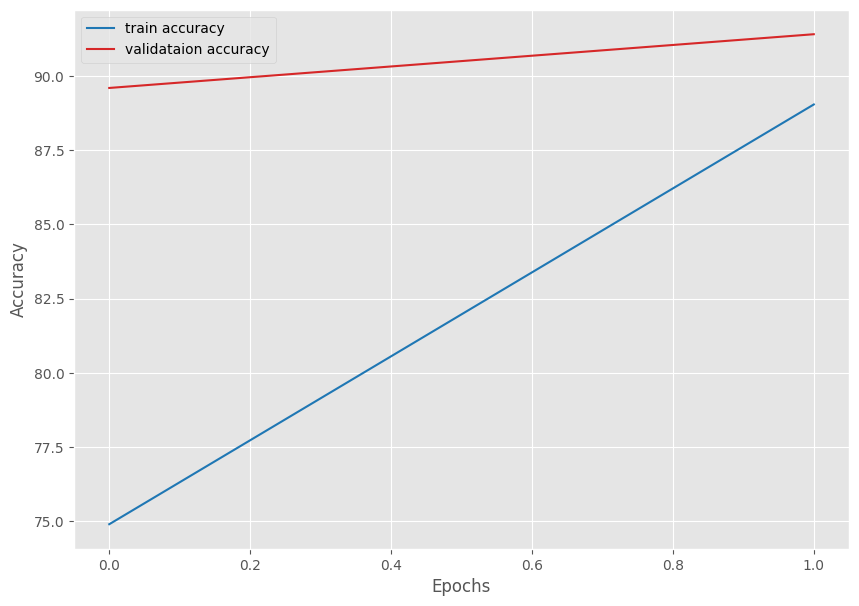

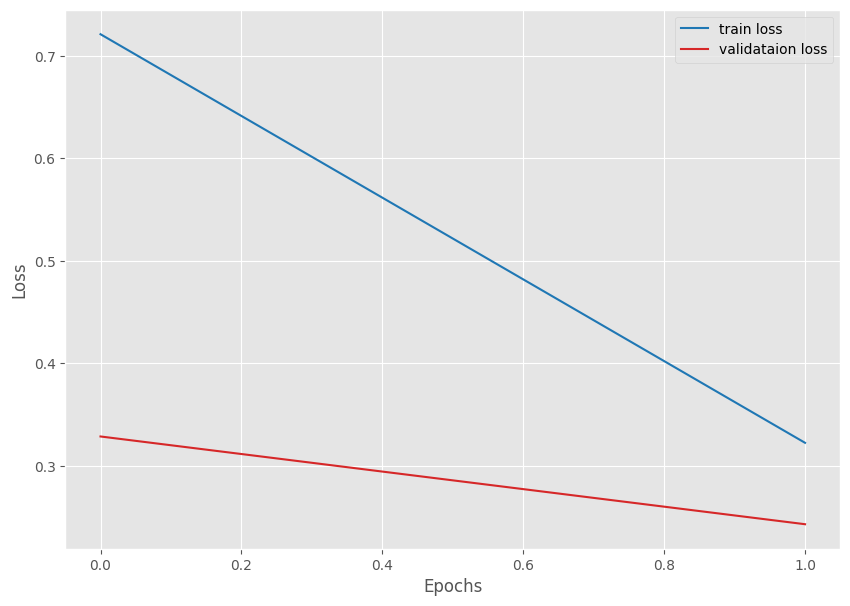

In [ ]:
# Save the trained model weights.
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

## **PROBANDO EL MODELO ENTRENADO RESNET18**


---



In [ ]:
def test(model, testloader, device):
    import numpy as np
    model.eval()
    print('Testing model')
    predictions_list = []
    ground_truth_list = []
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass.
            outputs = model(image)
            # Softmax probabilities.
            predictions = torch.softmax(outputs, dim=1).cpu().numpy()
            # Predicted class number.
            output_class = np.argmax(predictions)
            # Append the GT and predictions to the respective lists.
            predictions_list.append(output_class)
            ground_truth_list.append(labels.cpu().numpy())
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()


    acc = 100. * (test_running_correct / len(testloader.dataset)) # porcentaje de predicciones correctas
    return acc

Cargamos el modelo entrenado dede la carpeta en la que fue guardado.

In [ ]:
out_path = '/content/drive/My Drive/descomprimido/'
checkpoint = torch.load(os.path.join(out_path , 'outputs', 'model.pth'))
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-56-4d25d533a3ea>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(out_path , 'outputs', 'model.pth'))


<All keys matched successfully>

Realizamos inferencias SOBRE TODO EL CONJUNTO DE PRUEBA.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1)
acc = test(model, test_loader, device)
print(f"Test accuracy: {acc:.3f}%")

Testing model


  0%|          | 0/817 [00:00<?, ?it/s]

Test accuracy: 90.942%
